<a href="https://colab.research.google.com/github/RDGopal/IB9CW0-Text-Analytics/blob/main/Exercise_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Lecture 1


From the `babynames.csv` file,

* Plot the total number of babies born each year, broken down by gender.
* Create a plot with year on the-axis and the most popular female name on the Y-axis.

In [ ]:
babynames = pd.read_csv('babynames.csv')

In [ ]:
babynames['namelength'] = babynames['name'].str.len()
print(babynames.head())

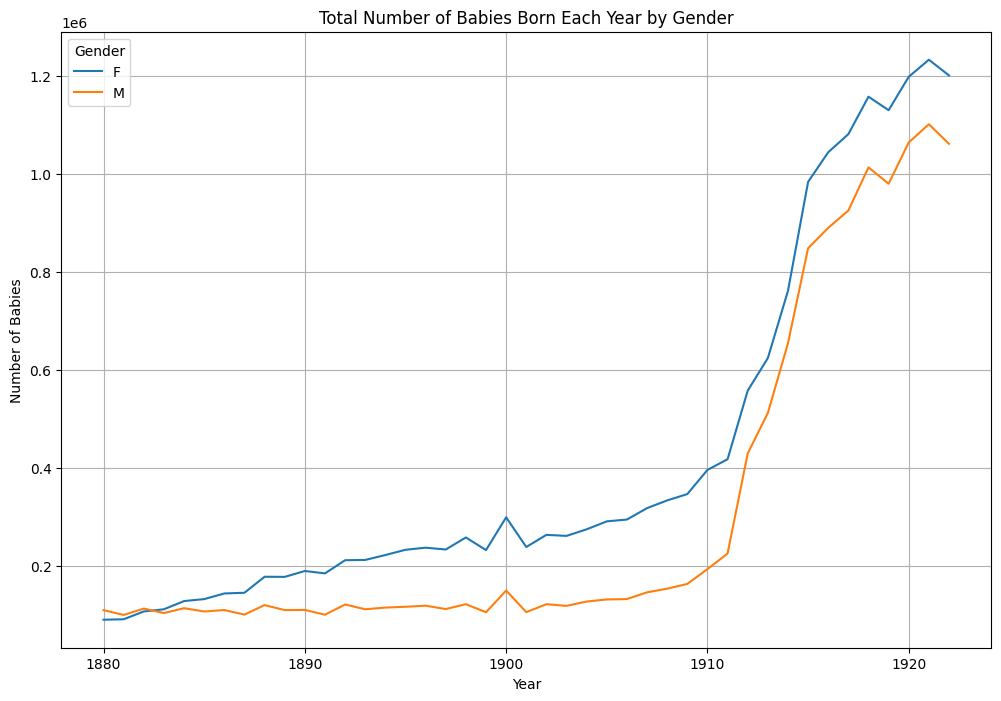

In [ ]:
# Group by 'year' and 'sex' and sum up 'n'
grouped = babynames.groupby(['year', 'sex'])['n'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size for better readability
for label, df in grouped.groupby('sex'):
    plt.plot(df['year'], df['n'], label=label)

plt.title('Total Number of Babies Born Each Year by Gender')
plt.xlabel('Year')
plt.ylabel('Number of Babies')
plt.legend(title='Gender')
plt.grid(True)
plt.show()

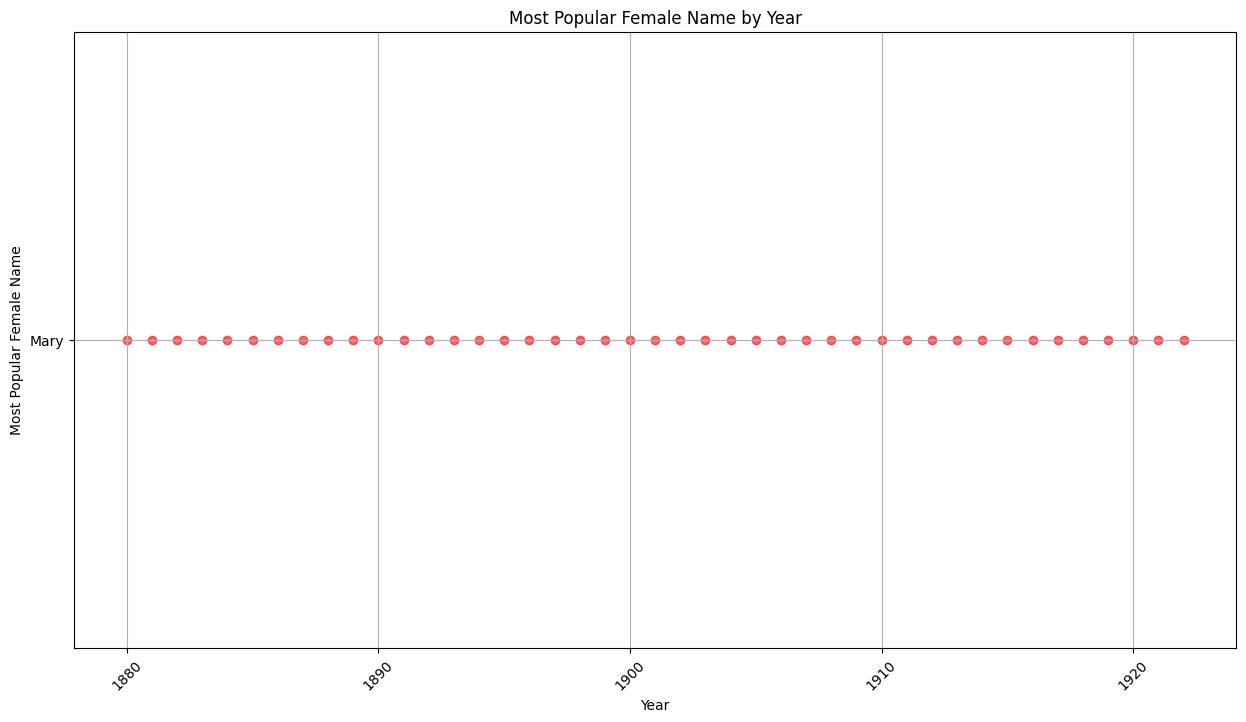

In [ ]:
# Filter for only female names
female_names = babynames[babynames['sex'] == 'F']

# Find the most popular name for each year
most_popular_each_year = female_names.loc[female_names.groupby('year')['n'].idxmax()]

# Assign a numeric index to each unique name for plotting
unique_names = most_popular_each_year['name'].unique()
name_to_index = {name: i for i, name in enumerate(unique_names)}
most_popular_each_year['name_index'] = most_popular_each_year['name'].map(name_to_index)

# Plotting
plt.figure(figsize=(15, 8))  # Set the figure size for better readability
plt.scatter(most_popular_each_year['year'], most_popular_each_year['name_index'], alpha=0.6, color='red')

# Customize the y-axis to show names instead of indices
plt.yticks(range(len(unique_names)), unique_names)

plt.title('Most Popular Female Name by Year')
plt.xlabel('Year')
plt.ylabel('Most Popular Female Name')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility

# Optional: Adjust x-axis ticks for better visibility
plt.xticks(ticks=most_popular_each_year['year'][::10])  # Show every 10th year

plt.grid(True)
plt.show()



In [ ]:
# Select only the relevant columns 'year' and 'name'
popular_names_df = most_popular_each_year[['year', 'name']].reset_index(drop=True)

# Display the DataFrame
print(popular_names_df)

From the `Reviews.csv` file:
* Find all mentions of the words 'refund' or 'late delivery'
* Find all hashtags (they start with #).

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Reviews.csv',nrows=5000)

In [ ]:
# drop data with missing values in the 'Review' column
df = df.dropna(axis=0, subset=['Review'])
df['Review'].head()

In [ ]:
# Define regex patterns
refund_pattern = r'\b(refund|late delivery)\b'
hashtag_pattern = r'#\w+'

# Function to find mentions of specific patterns
def find_mentions(text, pattern):
    return re.findall(pattern, text, flags=re.IGNORECASE)

# Apply functions to create new columns
df['Refund_Late_Delivery'] = df['Review'].apply(lambda x: find_mentions(x, refund_pattern))
df['Hashtags'] = df['Review'].apply(lambda x: re.findall(hashtag_pattern, x, flags=re.IGNORECASE))

In [ ]:
# Filter the DataFrame to include only rows where either 'Refund_Late_Delivery' or 'Hashtags' are not empty
filtered_data = df[(df['Refund_Late_Delivery'].apply(bool)) | (df['Hashtags'].apply(bool))]

# Display the 'Review', 'Refund_Late_Delivery', and 'Hashtags' columns
filtered_data[['Review', 'Refund_Late_Delivery', 'Hashtags']]


Read the `fakenews.csv` file.

* Find all mentions of Prince Harry.
* Find all mentions of Prince Harry that is fake news.
* Find all phonenumbers.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/fakenews.csv')

# drop data with missing values in the 'text' column
df = df.dropna(axis=0, subset=['text'])
df['text'].head()

In [ ]:
# Find all mentions of Prince Harry
df['Prince_Harry_Mentions'] = df['text'].apply(lambda x: 'Prince Harry' in x)

In [ ]:
# Adjust this based on the actual column and values that identify fake news
df['Prince_Harry_Fake_News'] = df.apply(lambda x: 'Prince Harry' in x['text'] and x['label'] == 1, axis=1)

In [ ]:
# Regex pattern for phone numbers (adjust pattern based on expected phone number formats)
phone_pattern = r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b'
df['Phone_Numbers'] = df['text'].apply(lambda x: re.findall(phone_pattern, x))

In [ ]:
# If you want to view only rows with mentions of Prince Harry
prince_harry_mentions = df[df['Prince_Harry_Mentions']]
prince_harry_mentions[['text', 'Prince_Harry_Mentions', 'Prince_Harry_Fake_News']]

In [ ]:
# If you want to see rows with mentions of Prince Harry that are fake news
prince_harry_fake_news = df[df['Prince_Harry_Fake_News']]
prince_harry_fake_news[['text', 'Prince_Harry_Fake_News']]

In [ ]:
# If you want to see rows with phone numbers
rows_with_phone_numbers = df[df['Phone_Numbers'].apply(len) > 0]
rows_with_phone_numbers[['text', 'Phone_Numbers']]

#Lecture 2

Read and preprocess the file `oct_delta.csv`

In [ ]:
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel,CoherenceModel,TfidfModel,Nmf,LsiModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/oct_delta.csv')

# drop data with missing values in the 'text' column
df = df.dropna(axis=0, subset=['text'])
df['text'].head()

In [ ]:
# Put it all into a function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = stopwords.words('english')
    extra_words = ['.','*',',']
    stop_words.extend(extra_words)
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [ ]:
df['text'] = df['text'].apply(preprocess_text)
df

Conduct frequency analysis with `oct_delta.csv` file.

In [ ]:
# Tokenize
df['tokens'] = df['text'].apply(nltk.word_tokenize)

In [ ]:
# create list of tokens
documents = df['tokens'].tolist()

# create the dictionary
dictionary = Dictionary(documents) # list of lists (documents)

# filter extremes from the dictionary (optional, but recommended)
dictionary.filter_extremes(no_below=5, no_above=0.5) # at least appears in 5 documents, no more than 50%

# create bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]

# create tf-idf representation
tfidf_model = TfidfModel(corpus)
tfidf_corpus = [tfidf_model[doc] for doc in corpus]

In [ ]:
!pip install matplotlib wordcloud

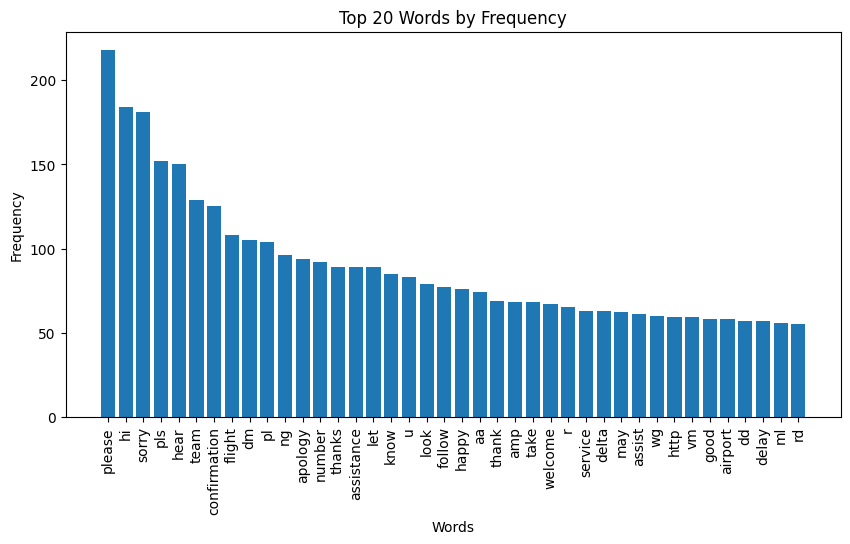

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Summing up the counts from the BoW corpus
total_word_count = Counter(word_id for document in corpus for word_id, count in document)

# Mapping back the word IDs to words
mapped_word_counts = [(dictionary[word_id], count) for word_id, count in total_word_count.items()]

# Sort words by frequency
sorted_word_counts = sorted(mapped_word_counts, key=lambda w: w[1], reverse=True)

# Let's plot the top words
plt.figure(figsize=(10, 5))
words, counts = zip(*sorted_word_counts[:40])
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words by Frequency')
plt.xticks(rotation=90)
plt.show()

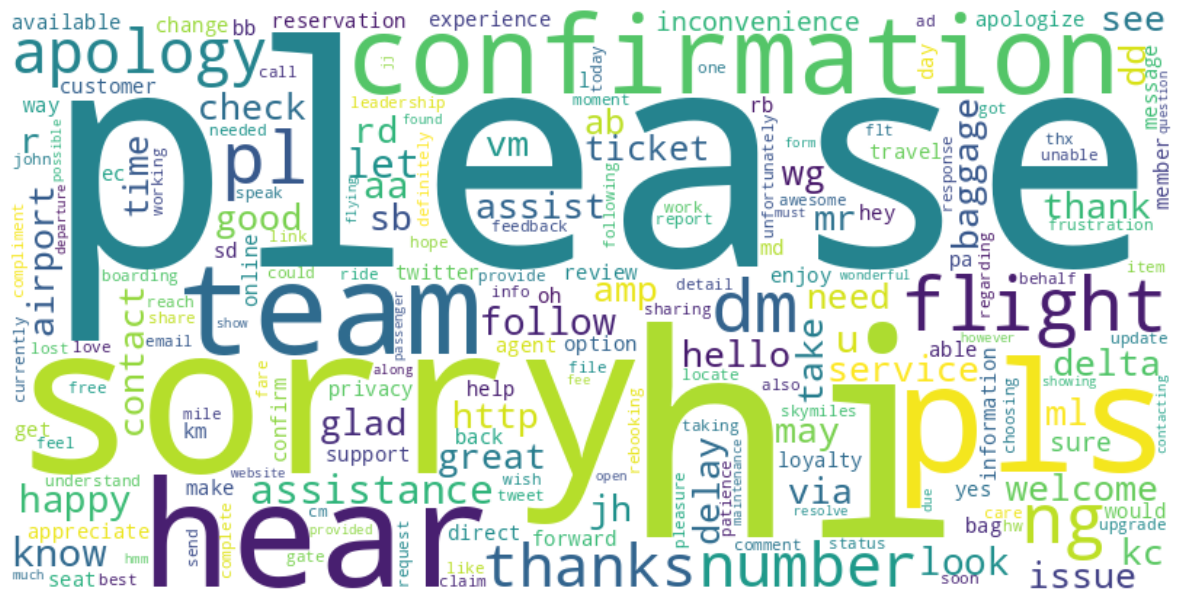

In [ ]:
from wordcloud import WordCloud

# Creating a dictionary for word cloud
word_freq_dict = dict(sorted_word_counts)

# Creating word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_freq_dict)

# Displaying the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


Run the following code to get a novel from HugginFace and conduct Zipf's law analysis.

In [ ]:
import requests
from nltk.tokenize import word_tokenize

# URL to the raw text file on GitHub
url ="https://datasets-server.huggingface.co/rows?dataset=JiggaBooJombs%2FNovelist&config=default&split=train&offset=0&length=100"

# Use requests to get the content of the file
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    text = response.text.lower()
    # Continue processing the text as needed
else:
    print("Failed to retrieve the file. Status code:", response.status_code)

# Tokenize the text
tokens = word_tokenize(text)

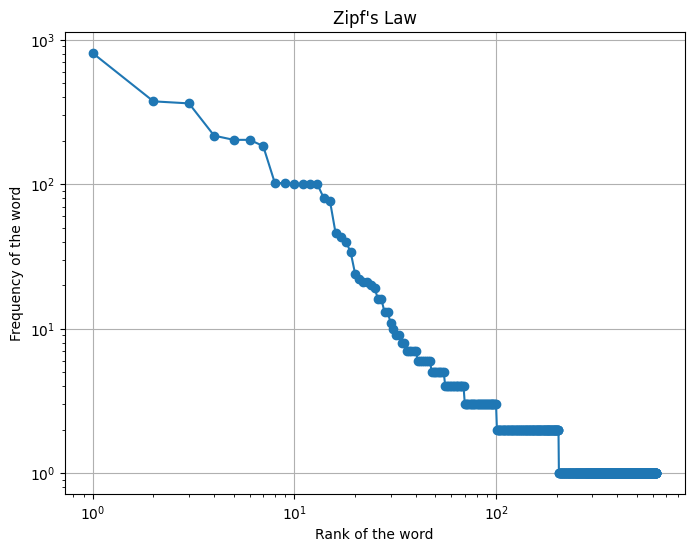

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Count frequencies
word_counts = Counter(tokens)

# Sort words by frequency
sorted_word_counts = word_counts.most_common()

# Prepare data for plotting
ranks = range(1, len(sorted_word_counts) + 1)
frequencies = [freq for _, freq in sorted_word_counts]

# Log-log plot
plt.figure(figsize=(8, 6))
plt.loglog(ranks, frequencies, marker="o")
plt.title('Zipf\'s Law')
plt.xlabel('Rank of the word')
plt.ylabel('Frequency of the word')
plt.grid(True)
plt.show()

Conduct POS analysis for `sms_spam.csv` and `oct_delta.csv` data.

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

The following is for `oct_delta.csv`. Repeat for `sms_spam.csv`

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/oct_delta.csv')

# drop data with missing values in the 'text' column
df = df.dropna(axis=0, subset=['text'])

In [ ]:
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
# Tokenize
df['tokens'] = df['text'].apply(word_tokenize)

# POS tagging the tokens for each document and create a flat list for all tokens
pos_tags = [tag for sublist in df['tokens'] for tag in nltk.pos_tag(sublist)]

# Count word frequencies (including the POS tags for uniqueness)
word_counts = Counter(pos_tags)

# Create a list of dictionaries to later convert to a DataFrame
data = [{'Word': word, 'POS': pos, 'WordCount': count} for (word, pos), count in word_counts.items()]

# Create the DataFrame
df_pos = pd.DataFrame(data)

df_pos

# Lecture 3

Conduct topic modeling with `sms_spam.csv`and `oct_delta.csv` data.

The following is for `oct_delta.csv`. Repeat for `sms_spam.csv`

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/oct_delta.csv')

# drop data with missing values in the 'text' column
df = df.dropna(axis=0, subset=['text'])

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Filter tokens that are nouns or adjectives
    # NN* for nouns, JJ* for adjectives
    tokens = [word for word, tag in tagged_tokens if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    return ' '.join(tokens)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df['text']= df['text'].apply(preprocess_text)

In [ ]:
# Tokenize
df['tokens'] = df['text'].apply(nltk.word_tokenize)

# create list of tokens
documents = df['tokens'].tolist()

# create the dictionary
dictionary = Dictionary(documents) # list of lists (documents)

# filter extremes from the dictionary (optional, but recommended)
dictionary.filter_extremes(no_below=5, no_above=0.5) # at least appears in 5 documents, no more than 50%

# create bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]

In [ ]:
# Set parameters
num_topics = 2
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.048*"sorry" + 0.033*"hi" + 0.028*"confirmation" + 0.024*"pls" + 0.022*"aa" + 0.021*"apologies" + 0.020*"thank" + 0.020*"delta" + 0.019*"thanks" + 0.019*"amp"')
(1, '0.044*"team" + 0.033*"flight" + 0.032*"ng" + 0.029*"number" + 0.027*"hi" + 0.026*"pl" + 0.022*"welcome" + 0.020*"happy" + 0.019*"rs" + 0.019*"ml"')


[0.3409436294305851, 0.35382065682470726, 0.35679330517546604, 0.35943305023208244]


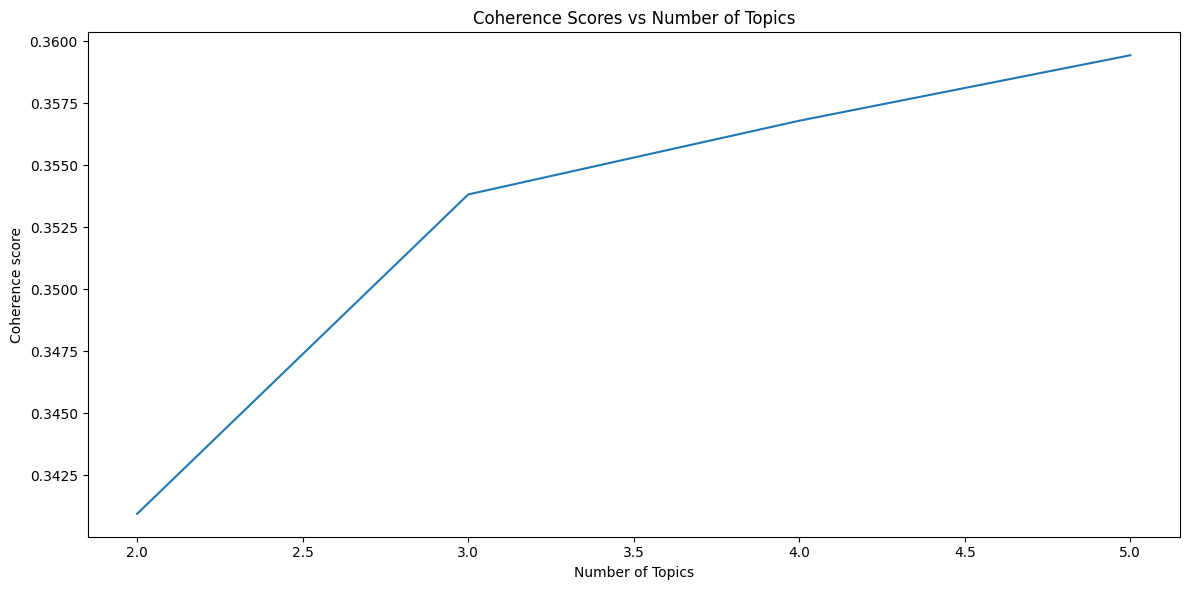

In [ ]:
import matplotlib.pyplot as plt

# Range of topics to evaluate
topic_range = range(2, 6)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()

In [ ]:
# Set optimal number of topics
num_topics = 3
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.073*"hi" + 0.049*"sorry" + 0.047*"team" + 0.028*"pls" + 0.024*"mr" + 0.024*"http" + 0.024*"service" + 0.020*"baggage" + 0.019*"kc" + 0.019*"assistance"')
(1, '0.047*"thanks" + 0.044*"flight" + 0.035*"welcome" + 0.032*"pl" + 0.026*"thank" + 0.024*"apologies" + 0.023*"rd" + 0.022*"great" + 0.022*"vm" + 0.021*"team"')
(2, '0.067*"confirmation" + 0.037*"sorry" + 0.037*"number" + 0.032*"delta" + 0.028*"ng" + 0.027*"amp" + 0.026*"follow" + 0.024*"pls" + 0.023*"pl" + 0.023*"happy"')


In [ ]:
# Print the top 10 terms for each topic
for topic_id in range(num_topics):
    top_terms = lda.show_topic(topic_id, topn=10)  # Get the top 10 terms for this topic
    terms = ', '.join([term for term, _ in top_terms])
    print(f"Topic {topic_id}: {terms}")

Topic 0: hi, sorry, team, pls, mr, http, service, baggage, kc, assistance
Topic 1: thanks, flight, welcome, pl, thank, apologies, rd, great, vm, team
Topic 2: confirmation, sorry, number, delta, ng, amp, follow, pls, pl, happy


# Lecture 4




Conduct sentiment analysis on `sms_spam.csv`. Assess if the average sentiment of the text is related to whether the message is `ham` or `spam`.

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/sms_spam.csv')

We will use VADER sentiment.

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the polarity_scores method to each text entry individually
df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the first few rows to verify
df[['text', 'sentiment']]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

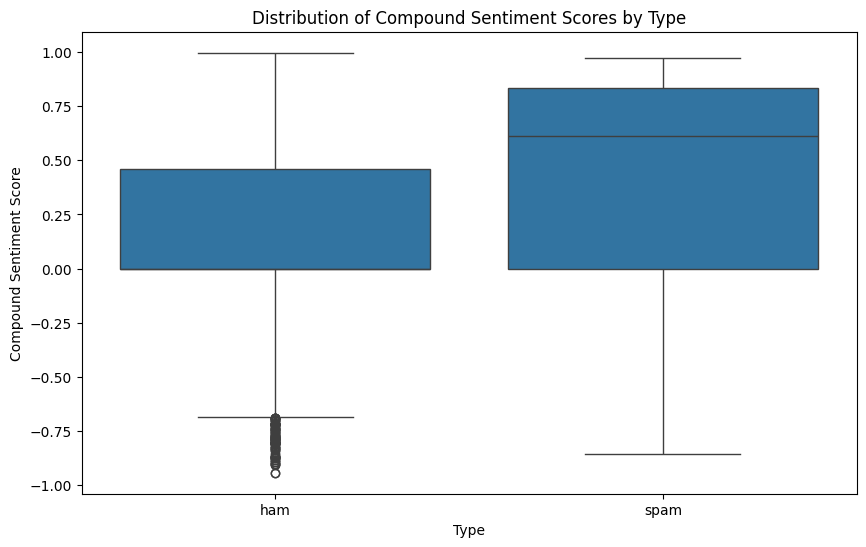

In [ ]:
# Create a boxplot showing the compound sentiment scores for each type
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.boxplot(x='type', y='sentiment', data=df)
plt.title('Distribution of Compound Sentiment Scores by Type')
plt.xlabel('Type')
plt.ylabel('Compound Sentiment Score')
plt.show()

Open the `kickstarter.csv` file, which contains information about various Kickstarter projects, such as their title, description, funding goal, number of backers, and state. The file was downloaded from https://webrobots.io/kickstarter-datasets/. Conduct sentiment analysis on the variable `blurb` and assess whether the sentiment is related to `state` which has values `successful`, `failed`, and `canceled`.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Kickstarter.csv')

In [ ]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the polarity_scores method to each text entry individually
df['sentiment'] = df['blurb'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the first few rows to verify
df[['blurb', 'sentiment']]

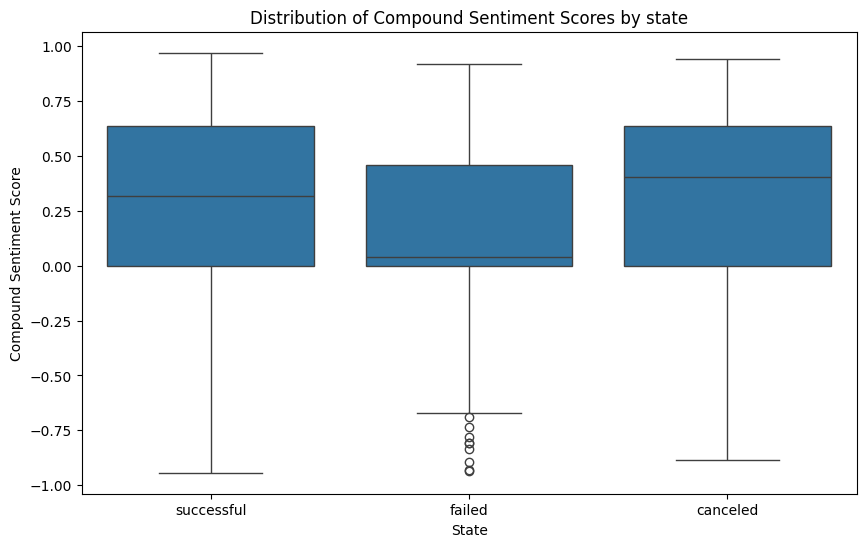

In [ ]:
# Create a boxplot showing the compound sentiment scores for each state
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.boxplot(x='state', y='sentiment', data=df)
plt.title('Distribution of Compound Sentiment Scores by state')
plt.xlabel('State')
plt.ylabel('Compound Sentiment Score')
plt.show()

#Lecture 5



Read the `Roomba.csv` file. Create a new variable called `rating` which has values `high` and `low`. If the `Stars` value is 4 or 5, then `rating` should be `high`, otherwise `low`. Build models to predict `rating` based on `Review`. Conduct topic modeling (10 topics) and sentiments of `Review` and use these to predict  `rating`.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Roomba.csv')

In [ ]:
df= df.dropna()

In [ ]:
# Create the 'rating' column based on 'Stars'
df['rating'] = df['Stars'].apply(lambda x: 'high' if x > 4 else 'low')
df.head()

,Date,Product,Stars,Title,Review,rating
0,2/28/15,iRobot Roomba 650 for Pets,5,Five Stars,You would not believe how well this works,high
1,1/12/15,iRobot Roomba 650 for Pets,4,Four Stars,You just walk away and it does the rest,low
2,12/26/13,iRobot Roomba 650 for Pets,5,Awesome love it.,You have to Roomba proof your house but once t...,high
3,8/4/13,iRobot Roomba 650 for Pets,3,Love-hate this vaccuum,"Yes, it's a fascinating, albeit expensive, bit...",low
4,12/22/15,iRobot Roomba 650 for Pets,5,This vacuum is fantastic!!,Years ago I bought one of the original Roomba'...,high


In [ ]:
# drop data with missing values in the 'Review' column
df = df.dropna(axis=0, subset=['Review'])

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the polarity_scores method to each text entry individually
df['sentiment'] = df['Review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the first few rows to verify
df[['Review', 'sentiment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Review,sentiment
0,You would not believe how well this works,-0.2057
1,You just walk away and it does the rest,0.0000
2,You have to Roomba proof your house but once t...,0.8720
3,"Yes, it's a fascinating, albeit expensive, bit...",0.9179
4,Years ago I bought one of the original Roomba'...,0.9789
...,...,...
628,Mom loves it. Period.,0.5719
629,May take a little micro managing at first. Run...,0.7650
630,many have mentioned that they name their roomb...,0.8119
631,"Man, buying a Roomba changed my life! It is so...",0.9947


Confusion Matrix:
 [[67 23]
 [26 11]]


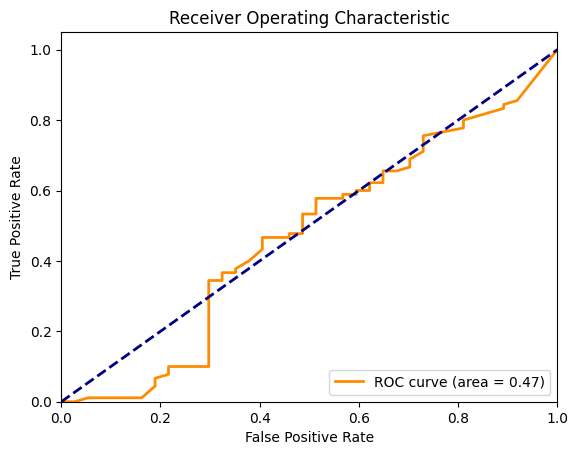

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for modeling
X = df[['sentiment']]  # Predictor
y= df['rating']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob,pos_label='high')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Roomba.csv')
df= df.dropna()
# Create the 'rating' column based on 'Stars'
df['rating'] = df['Stars'].apply(lambda x: 'high' if x > 4 else 'low')
# drop data with missing values in the 'Review' column
df = df.dropna(axis=0, subset=['Review'])

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

In [ ]:

if isinstance(df['Review'].iloc[0], str):
    df['text_preprocessed'] = df['Review'].apply(lambda x: x.split())

# Create a Dictionary and Corpus from the preprocessed text
id2word_preprocessed = corpora.Dictionary(df['text_preprocessed'])
corpus_preprocessed = [id2word_preprocessed.doc2bow(text) for text in df['text_preprocessed']]

# Step 2: Initialize and fit the LDA model
lda_model_preprocessed = LdaModel(corpus=corpus_preprocessed, id2word=id2word_preprocessed, num_topics=10, random_state=42, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 3: Extract Topic Distributions
topic_distributions_preprocessed = [lda_model_preprocessed.get_document_topics(bow) for bow in corpus_preprocessed]

# Normalize topic distributions and ensure each document has distribution over all 10 topics
def normalize_topic_distributions(distributions, num_topics=10):
    normalized = []
    for dist in distributions:
        doc_topics = dict(dist)
        normalized.append([doc_topics.get(i, 0) for i in range(num_topics)])
    return normalized

# Normalize topic distributions
normalized_topics_preprocessed = normalize_topic_distributions(topic_distributions_preprocessed)

# Create DataFrame with topic distributions
topics_df_preprocessed = pd.DataFrame(normalized_topics_preprocessed, columns=[f"Topic{i+1}" for i in range(10)])

# Concatenate original DataFrame with topics DataFrame
df_with_topics_gensim_preprocessed = pd.concat([df, topics_df_preprocessed], axis=1)

# Display the DataFrame with topics
df_with_topics_gensim_preprocessed.head()

,Date,Product,Stars,Title,Review,rating,text_preprocessed,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,2/28/15,iRobot Roomba 650 for Pets,5.0,Five Stars,You would not believe how well this works,high,"[You, would, not, believe, how, well, this, wo...",0.0,0.029124,0.0,0.000000,0.938060,0.0,0.0,0.0,0.000000,0.0
1,1/12/15,iRobot Roomba 650 for Pets,4.0,Four Stars,You just walk away and it does the rest,low,"[You, just, walk, away, and, it, does, the, rest]",0.0,0.960713,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,12/26/13,iRobot Roomba 650 for Pets,5.0,Awesome love it.,You have to Roomba proof your house but once t...,high,"[You, have, to, Roomba, proof, your, house, bu...",0.0,0.937832,0.0,0.000000,0.000000,0.0,0.0,0.0,0.047059,0.0
3,8/4/13,iRobot Roomba 650 for Pets,3.0,Love-hate this vaccuum,"Yes, it's a fascinating, albeit expensive, bit...",low,"[Yes,, it's, a, fascinating,, albeit, expensiv...",0.0,0.255565,0.0,0.740502,0.000000,0.0,0.0,0.0,0.000000,0.0
4,12/22/15,iRobot Roomba 650 for Pets,5.0,This vacuum is fantastic!!,Years ago I bought one of the original Roomba'...,high,"[Years, ago, I, bought, one, of, the, original...",0.0,0.000000,0.0,0.000000,0.997349,0.0,0.0,0.0,0.000000,0.0


In [ ]:
df_with_topics_gensim_preprocessed = df_with_topics_gensim_preprocessed.dropna()

Confusion Matrix:
 [[66 24]
 [30  7]]


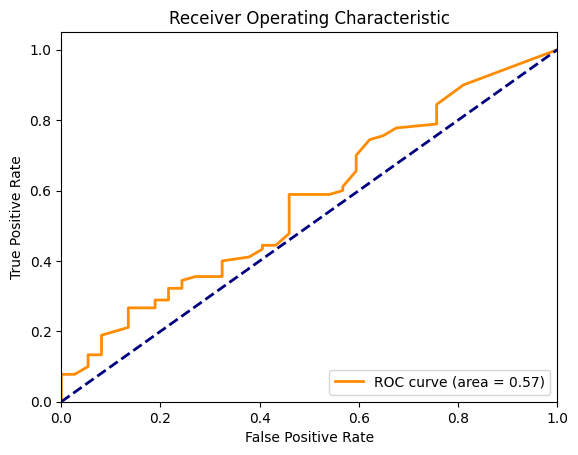

,Feature,Importance
1,Topic2,0.572083
4,Topic5,0.239647
3,Topic4,0.042429
0,Topic1,0.036614
8,Topic9,0.029260
2,Topic3,0.027910
5,Topic6,0.019001
7,Topic8,0.017325
6,Topic7,0.015730


In [ ]:
# Prepare the data for modeling, excluding one topic for independence
X = df_with_topics_gensim_preprocessed[[f"Topic{i+1}" for i in range(9)]]  # Using Topic1 to Topic9
y = df_with_topics_gensim_preprocessed['rating']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate ROC curve and AUC if both classes are present in the test set
if len(np.unique(y_test)) > 1:
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='high')
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted. The test set does not contain both classes.")

# Feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances

Read the `imdb.csv` file and predict the sentiment based on the review of the movie.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/imdb.csv')
df= df.dropna()

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9994,"First off, this is the worst movie I've ever s...",negative
9995,"Fun, entertaining movie about WWII German spy ...",positive
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative


In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the polarity_scores method to each text entry individually
df['review_sentiment'] = df['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the first few rows to verify
df[['review_sentiment', 'sentiment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review_sentiment,sentiment
0,-0.9951,positive
1,0.9641,positive
2,0.9605,positive
3,-0.9213,negative
4,0.9744,positive
...,...,...
9994,-0.7160,negative
9995,0.9756,positive
9996,0.9220,negative
9997,-0.9485,negative


Confusion Matrix:
 [[595 365]
 [322 718]]


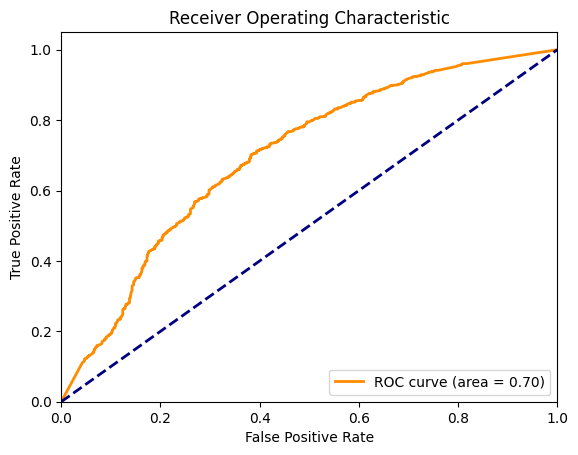

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for modeling
X = df[['review_sentiment']]  # Predictor
y= df['sentiment']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob,pos_label='positive')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

In [ ]:
if isinstance(df['review'].iloc[0], str):
    df['text_preprocessed'] = df['review'].apply(lambda x: x.split())

# Create a Dictionary and Corpus from the preprocessed text
id2word_preprocessed = corpora.Dictionary(df['text_preprocessed'])
corpus_preprocessed = [id2word_preprocessed.doc2bow(text) for text in df['text_preprocessed']]

# Step 2: Initialize and fit the LDA model
lda_model_preprocessed = LdaModel(corpus=corpus_preprocessed, id2word=id2word_preprocessed, num_topics=10, random_state=42, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 3: Extract Topic Distributions
topic_distributions_preprocessed = [lda_model_preprocessed.get_document_topics(bow) for bow in corpus_preprocessed]

# Normalize topic distributions and ensure each document has distribution over all 10 topics
def normalize_topic_distributions(distributions, num_topics=10):
    normalized = []
    for dist in distributions:
        doc_topics = dict(dist)
        normalized.append([doc_topics.get(i, 0) for i in range(num_topics)])
    return normalized

# Normalize topic distributions
normalized_topics_preprocessed = normalize_topic_distributions(topic_distributions_preprocessed)

# Create DataFrame with topic distributions
topics_df_preprocessed = pd.DataFrame(normalized_topics_preprocessed, columns=[f"Topic{i+1}" for i in range(10)])

# Concatenate original DataFrame with topics DataFrame
df_with_topics_gensim_preprocessed = pd.concat([df, topics_df_preprocessed], axis=1)

# Display the DataFrame with topics
df_with_topics_gensim_preprocessed.head()

,review,sentiment,review_sentiment,text_preprocessed,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,One of the other reviewers has mentioned that ...,positive,-0.9951,"[One, of, the, other, reviewers, has, mentione...",0,0.174150,0.0,0.825505,0.0,0,0.0,0.0,0.0,0
1,A wonderful little production. <br /><br />The...,positive,0.9641,"[A, wonderful, little, production., <br, /><br...",0,0.477961,0.0,0.521377,0.0,0,0.0,0.0,0.0,0
2,I thought this was a wonderful way to spend ti...,positive,0.9605,"[I, thought, this, was, a, wonderful, way, to,...",0,0.117862,0.0,0.881509,0.0,0,0.0,0.0,0.0,0
3,Basically there's a family where a little boy ...,negative,-0.9213,"[Basically, there's, a, family, where, a, litt...",0,0.081019,0.0,0.918231,0.0,0,0.0,0.0,0.0,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.9744,"[Petter, Mattei's, ""Love, in, the, Time, of, M...",0,0.658904,0.0,0.340650,0.0,0,0.0,0.0,0.0,0


Confusion Matrix:
 [[546 414]
 [465 575]]


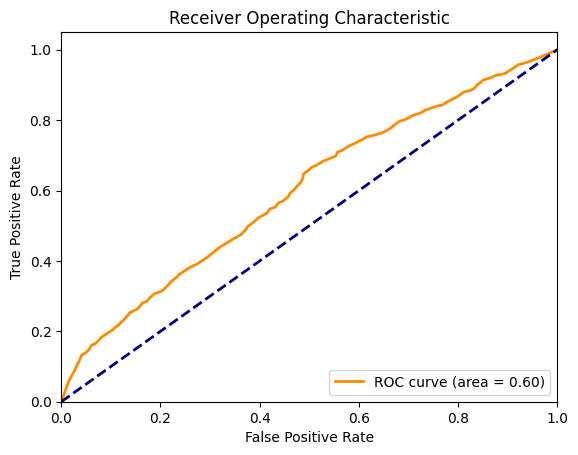

,Feature,Importance
3,Topic4,0.547233
1,Topic2,0.442724
4,Topic5,0.004712
8,Topic9,0.003261
7,Topic8,0.000899
6,Topic7,0.000787
2,Topic3,0.000385
0,Topic1,0.000000
5,Topic6,0.000000


In [ ]:
df_with_topics_gensim_preprocessed = df_with_topics_gensim_preprocessed.dropna()
# Prepare the data for modeling, excluding one topic for independence
X = df_with_topics_gensim_preprocessed[[f"Topic{i+1}" for i in range(9)]]  # Using Topic1 to Topic9
y = df_with_topics_gensim_preprocessed['sentiment']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate ROC curve and AUC if both classes are present in the test set
if len(np.unique(y_test)) > 1:
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='positive')
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted. The test set does not contain both classes.")

# Feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances

#Lecture 6

Create next word prediction and text generation based on the novel Moby Dick, by Herman Melville. You can access it with `melville-moby_dick.txt`.
Create text generation based on the file `tinyshakespeare.txt` using n-grams.
Repeat with embeddings.
Find the closest words to 'king' and plot the results.

In [ ]:
import nltk
nltk.download('gutenberg')  # Make sure the Gutenberg corpus is downloaded
from nltk.corpus import gutenberg

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [ ]:
# Load "Moby Dick" text
mmd = gutenberg.raw('melville-moby_dick.txt')

# Print the first 500 characters
print(mmd[:500])

[Moby Dick by Herman Melville 1851]


ETYMOLOGY.

(Supplied by a Late Consumptive Usher to a Grammar School)

The pale Usher--threadbare in coat, heart, body, and brain; I see him
now.  He was ever dusting his old lexicons and grammars, with a queer
handkerchief, mockingly embellished with all the gay flags of all the
known nations of the world.  He loved to dust his old grammars; it
somehow mildly reminded him of his mortality.

"While you take in hand to school others, and to teac


In [ ]:
import nltk
from nltk import word_tokenize, ngrams
from collections import defaultdict, Counter
nltk.download('punkt')

# Tokenize the text
tokens = word_tokenize(mmd.lower())  # Convert to lower case

# Generate trigrams from the tokens
trigrams = list(ngrams(tokens, 3))
trigram_freq = defaultdict(Counter)

# Populate the frequencies of trigrams
for w1, w2, w3 in trigrams:
    trigram_freq[(w1, w2)][w3] += 1

# Function to predict the next word
def predict_next_word(w1, w2):
    if (w1, w2) in trigram_freq:
        # Get the most common next word for the given bigram (w1, w2)
        return trigram_freq[(w1, w2)].most_common(1)[0][0]
    else:
        return None

# Function to generate text
def generate_text(start_words, num_words):
    if len(start_words) < 2:
        return "Please provide at least two starting words."

    generated_words = list(start_words)
    for _ in range(num_words):
        next_word = predict_next_word(generated_words[-2], generated_words[-1])
        if next_word is None:
            break  # Break if no next word is found
        generated_words.append(next_word)

    return ' '.join(generated_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Predict next word based on 3-grams
print("Next word:", predict_next_word('he', 'was'))

Next word: a


In [ ]:
# Function for text generation
import random

# Function to predict the next word with randomness
def predict_next_word(w1, w2):
    if (w1, w2) in trigram_freq:
        next_words = list(trigram_freq[(w1, w2)].elements())
        return random.choice(next_words) if next_words else None
    else:
        return None

# Function to generate text with randomness
def generate_text(start_words, num_words):
    if len(start_words) < 2:
        return "Please provide at least two starting words."

    generated_words = list(start_words)
    for _ in range(num_words):
        next_word = predict_next_word(generated_words[-2], generated_words[-1])
        if next_word is None:
            break  # Break if no next word is found
        generated_words.append(next_word)

    return ' '.join(generated_words)


In [ ]:
# Text Generation
start_words = ("he", "was")
generate_text(start_words, 500)

"he was going on with his hands . '' all your meals for three days previous , bildad , avast there , and grappling the beefsteaks towards him . he 's robbed a widow ; '' or minute vertical tube formed at the top of his hands off ! this fish , whose captain and crew , the great world 's loom , thy unparticipated grief . ho , ho ! more intolerable than fiends ' glarings is a new face altogether , the captain , addressing ahab ; `` i will dismember my dismemberer . now , queequeg , shaking himself , while the two reversed needles there , wrapped in outer darkness . instantly the yards to the pequod must have been visible at the watches , his spout was oft seen from the table , ahab cried out to them , because he could take it , like man , too , remain wholly inexplicable . in short , everything betokened that some young seals that had only just lifted my foot against the proceedings of the enormousness of that proceeding being entirely unnecessary . it was found dead in my brief sleep i h

Create text generation based on the file `tinyshakespeare.txt` using n-grams.

Repeat with embeddings.

Find the closest words to 'king' and plot the results.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

import requests

# URL to the raw text file on GitHub
url = 'https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/tinyshakespeare.txt'

# Use requests to get the content of the file
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    text = response.text.lower()
    # Continue processing the text as needed
else:
    print("Failed to retrieve the file. Status code:", response.status_code)

# Tokenize the text
tokens = word_tokenize(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
text[0:500]

"first citizen:\nbefore we proceed any further, hear me speak.\n\nall:\nspeak, speak.\n\nfirst citizen:\nyou are all resolved rather to die than to famish?\n\nall:\nresolved. resolved.\n\nfirst citizen:\nfirst, you know caius marcius is chief enemy to the people.\n\nall:\nwe know't, we know't.\n\nfirst citizen:\nlet us kill him, and we'll have corn at our own price.\nis't a verdict?\n\nall:\nno more talking on't; let it be done: away, away!\n\nsecond citizen:\none word, good citizens.\n\nfirst citizen:\nwe are accounted poor"

In [ ]:
# Generate trigrams from the tokens
trigrams = list(ngrams(tokens, 3))
trigram_freq = defaultdict(Counter)

# Populate the frequencies of trigrams
for w1, w2, w3 in trigrams:
    trigram_freq[(w1, w2)][w3] += 1

# Function to predict the next word
def predict_next_word(w1, w2):
    if (w1, w2) in trigram_freq:
        # Get the most common next word for the given bigram (w1, w2)
        return trigram_freq[(w1, w2)].most_common(1)[0][0]
    else:
        return None

# Function to generate text
def generate_text(start_words, num_words):
    if len(start_words) < 2:
        return "Please provide at least two starting words."

    generated_words = list(start_words)
    for _ in range(num_words):
        next_word = predict_next_word(generated_words[-2], generated_words[-1])
        if next_word is None:
            break  # Break if no next word is found
        generated_words.append(next_word)

    return ' '.join(generated_words)

In [ ]:
# Predict next word based on 3-grams
print("Next word:", predict_next_word('be', 'done'))

Next word: ,


In [ ]:
# Function for text generation
import random

# Function to predict the next word with randomness
def predict_next_word(w1, w2):
    if (w1, w2) in trigram_freq:
        next_words = list(trigram_freq[(w1, w2)].elements())
        return random.choice(next_words) if next_words else None
    else:
        return None

# Function to generate text with randomness
def generate_text(start_words, num_words):
    if len(start_words) < 2:
        return "Please provide at least two starting words."

    generated_words = list(start_words)
    for _ in range(num_words):
        next_word = predict_next_word(generated_words[-2], generated_words[-1])
        if next_word is None:
            break  # Break if no next word is found
        generated_words.append(next_word)

    return ' '.join(generated_words)

In [ ]:
# Text Generation
start_words = ("to", "be")
generate_text(start_words, 500)

"to be ? what is the argument no longer hold me not thy master cut out and sewed up again ; 'twere no charity ; made glory base and sovereignty a slave of nature and the lips of those branches by the woman 's general ; but stir not you till you are more beautiful than any woman wrong 'd by falsehood of his face i have , my lord , you are learn 'd me in . i ca n't say your queen , bearing a tartar 's painted bow of lath , scaring the ladies have prevail 'd as many as you were lesson 'd , the traitor in ? i am in all the devils are here , i see , two lads that thought he would not have been , or one destroyed : a good wager , first begins to crow ? sebastian : his name is ominous to noble peers ! within thine eyes ; one who never feels the wanton spoil of phoebus ' lodging : such a cuff that down fell priest and clerk ? well i love a tender thing . king henry vi king henry vi : and as curst and shrewd as socrates ' xanthippe , or any of your husband king , yet in this island we arrived ;

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Assuming `sas` contains the raw text of "Sense and Sensibility"
tokens = word_tokenize(text.lower())  # Tokenize and convert to lower case

# Organize the tokens into sentences, Word2Vec needs data in format of list of lists of tokens
sentences = [tokens[i:i+100] for i in range(0, len(tokens), 100)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Train the CBOW model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)  # sg=0 specifies CBOW


In [ ]:
import random

def predict_next_word_cbow(current_words, topn=5):
    # Ensure the model is trained with all the words in current_words
    current_words = [word for word in current_words if word in model.wv.key_to_index]
    if not current_words:
        return "Unknown words"

    # Fetch top 'n' similar words based on the positive example of the current words
    similar_words = model.wv.most_similar(positive=current_words, topn=topn)

    # Extract words and their similarity scores
    words, scores = zip(*similar_words)

    # Normalize scores to form a probability distribution
    total_score = sum(scores)
    probabilities = [score / total_score for score in scores]

    # Randomly choose one word based on their similarity scores as probabilities
    next_word = random.choices(words, weights=probabilities, k=1)[0]
    return next_word

In [ ]:
def generate_text_cbow(start_words, num_words):
    generated_words = start_words.split()
    for _ in range(num_words):
        next_word = predict_next_word_cbow(generated_words[-2:], topn=10)  # Use top 10 words for randomness
        generated_words.append(next_word)
    return ' '.join(generated_words)

In [ ]:
generate_text_cbow("to be", 500)

"to be bear proceed straight command else sworn bound else never sleep shame soon sleep shame use lie without shame after walls change soon means best without fast received given rough whilst drink lest fast without best sworn yourself ere best fast sworn lie often use soon off while above open o'er off lives proud same lies fearful sad between lost sad new music fearful new ten years new thousand between ears black souls under days high ears souls under high lives fearful even kind gold even lies kind even lies sad even fearful days lives wind deadly gold forth fearful under between law half black days ears between strength under cold black half pride law fearful cold another music black new years between sad mortal new fearful mortal music years dark mortal law black music cold tender half cold another tender itself another cold tender another age fall hours himself two many youth weak strength hours souls half days power law cold days black law between fearful years something mortal

In [ ]:
def find_closest_words(input_word, topn=10):
    if input_word in model.wv.key_to_index:
        # Find the topn most similar words
        similar_words = model.wv.most_similar(positive=[input_word], topn=topn)
        return similar_words  # This returns a list of tuples (word, similarity)
    else:
        return f"The word '{input_word}' is not in the vocabulary."

In [ ]:
find_closest_words("king", 10)

[('vi', 0.983817458152771),
 ('iii', 0.9834522604942322),
 ('edward', 0.9820353388786316),
 ('henry', 0.9816784262657166),
 ('xi', 0.9805954694747925),
 ('iv', 0.9771915078163147),
 ('duke', 0.975147545337677),
 ('lewis', 0.9750311374664307),
 ('ii', 0.9749794602394104),
 ('richard', 0.9740995764732361)]

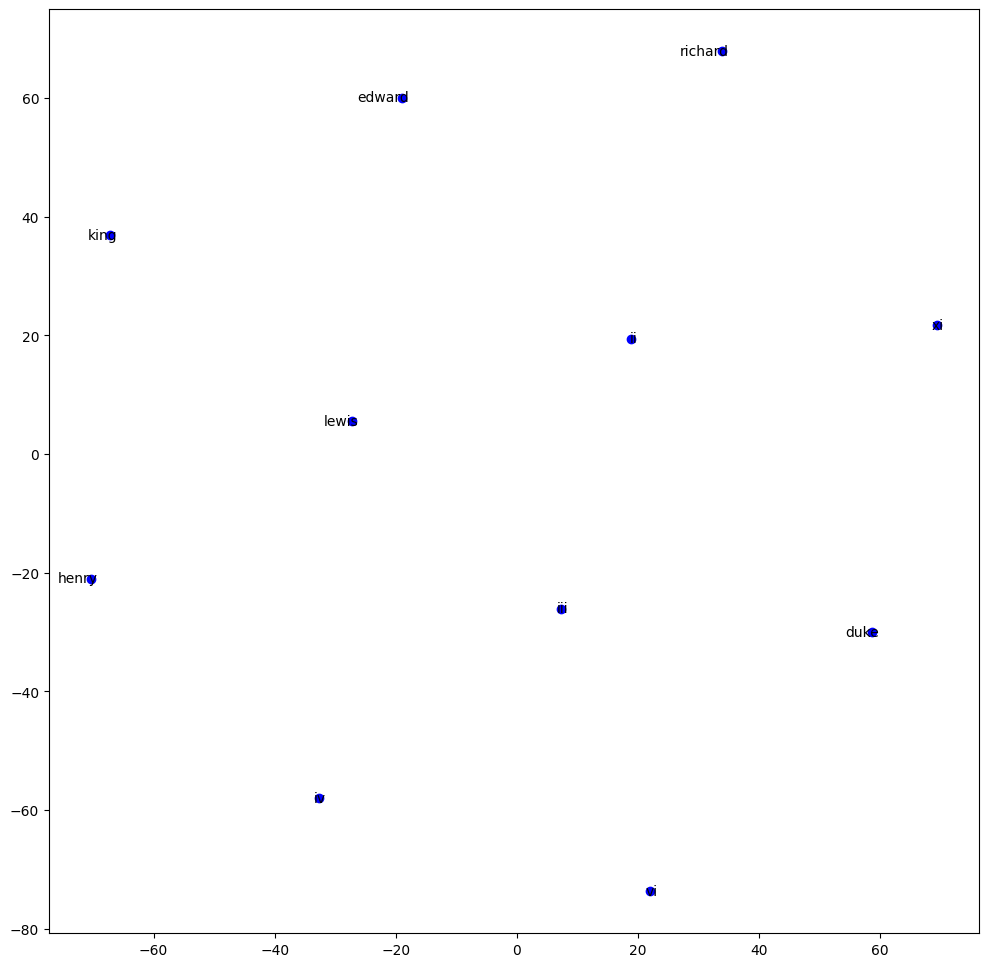

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_closest_words(model, input_word, topn=20):
    if input_word not in model.wv.key_to_index:
        print(f"The word '{input_word}' is not in the vocabulary.")
        return

    # Get the closest words specified by 'topn'
    closest_words = model.wv.most_similar(positive=[input_word], topn=topn)
    words = [word for word, _ in closest_words]
    words.append(input_word)  # Also include the input word

    # Extract the corresponding vectors
    word_vectors = np.array([model.wv[word] for word in words])

    # Use t-SNE to reduce dimensionality
    perplexity_value = min(30, len(words) - 1)  # Ensure perplexity is less than the number of samples
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    Y = tsne.fit_transform(word_vectors)

    # Plotting
    plt.figure(figsize=(12, 12))
    plt.scatter(Y[:, 0], Y[:, 1], color='blue')

    for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, -5),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.show()

# Example usage of the function
plot_closest_words(model, "king", topn=10)

#Lecture 7

Read the `imdb.csv` file and predict the sentiment based on the embeddings of the review of the movie.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/imdb.csv')
df= df.dropna()

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9994,"First off, this is the worst movie I've ever s...",negative
9995,"Fun, entertaining movie about WWII German spy ...",positive
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative


In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocess and tag each message in the dataset
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['review'])]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocess and tag each message in the dataset
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['review'])]

# Define and train the Doc2Vec model
model = Doc2Vec(vector_size=40, min_count=2, epochs=30)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Create embeddings and expand each element into separate columns
embeddings = [model.infer_vector(word_tokenize(text.lower())) for text in df['review']]
df_embeddings = pd.DataFrame(embeddings, columns=[f'embed_{i}' for i in range(len(embeddings[0]))])
df = pd.concat([df, df_embeddings], axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np



# Select embedding columns as features. This assumes embedding column names are like 'embed_0', 'embed_1', ..., 'embed_39'
X = df.loc[:, df.columns.str.startswith('embed_')]
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. embedding %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Read the document `Machine_stops.pdf` and implement semantic search over it.

In [ ]:
%pip install PyPDF2

In [ ]:
import requests
from PyPDF2 import PdfReader
from io import BytesIO

# URL to the raw PDF file on GitHub
url = 'https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Machine_stops.pdf'

# Use requests to get the content of the PDF file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Use BytesIO to convert the bytes response to a file-like object
    pdf_file = BytesIO(response.content)

    # Now you can use PdfReader to read the file
    reader = PdfReader(pdf_file)

    # Initialize a variable to hold all extracted text
    full_text = ""

    # Iterate over each page in the PDF file
    for page in reader.pages:
        text = page.extract_text()
        if text:  # Check if text was successfully extracted
            full_text += text + "\n"  # Append the text of each page

    text = full_text

else:
    print("Failed to download the file. Status code:", response.status_code)

In [ ]:
# Split the text into sentences
sentences = re.split(r'\.\s+', text)

# Clean and preprocess the text
df = pd.DataFrame({'text': sentences})
df['clean_text'] = df['text'].str.lower()
df['clean_text'] = df['clean_text'].str.replace('[^a-z\s]', '', regex=True)
df['clean_text'] = df['clean_text'].str.replace('\s+', ' ', regex=True)
df['sentence_id'] = np.arange(len(df))

In [ ]:
df

,text,clean_text,sentence_id,doc2vec_embedding
0,TheMachineStops\nbyE,themachinestops bye,0,"[-0.03675613, 0.06996772, 0.033624355, 0.01729..."
1,M,m,1,"[-0.04137362, 0.07814331, 0.04146192, 0.017708..."
2,Forster\nFirstpublished inthe Oxfordand Cambri...,forster firstpublished inthe oxfordand cambrid...,2,"[-0.037226707, 0.07839918, 0.047733657, 0.0376..."
3,"It is lighted\nneither by windownor by lamp, y...",it is lighted neither by windownor by lamp yet...,3,"[-0.031093545, 0.048073266, 0.030975906, 0.021..."
4,"There are no apertures\nforventilation,yetthea...",there are no apertures forventilationyettheair...,4,"[-0.017202424, 0.02746406, 0.017250357, 0.0088..."
...,...,...,...,...
673,Transcribed from TheEternalMomentandotherStori...,transcribed from theeternalmomentandotherstori...,673,"[-0.03377305, 0.059189074, 0.029150914, 0.0196..."
674,"(London, 1928) and The Collected Tales of E",london and the collected tales of e,674,"[-0.012142413, 0.03477182, 0.017440002, 0.0126..."
675,M,m,675,"[-0.042109564, 0.078655705, 0.042105656, 0.017..."
676,"Forster , The Modern Library (New York,\n1968)",forster the modern library new york,676,"[-0.037267156, 0.06992199, 0.036353968, 0.0178..."


In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize

# Tokenizing and tagging
tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(df['clean_text'])]

# Training a Doc2Vec model
model = Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Saving embeddings
df['doc2vec_embedding'] = [model.infer_vector(word_tokenize(row['clean_text'])) for index, row in df.iterrows()]

In [ ]:
def find_top_10_similar_sentences(df, query, model):
    query_embedding = model.infer_vector(word_tokenize(query.lower()))
    embeddings_matrix = np.vstack(df['doc2vec_embedding'])
    similarities = cosine_similarity([query_embedding], embeddings_matrix)
    top_10_indices = np.argsort(similarities[0])[::-1][:5]
    return df.iloc[top_10_indices]['text']

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity  # Import cosine_similarity

# Set display options
pd.set_option('display.max_colwidth', None)  # Ensure no truncation
pd.set_option('display.max_rows', None)  # Display any number of rows

query = "there are no apertures"
top_10_sentences = find_top_10_similar_sentences(df, query, model)
for sentence in top_10_sentences:
    print(sentence)
    print()


There are no apertures
forventilation,yettheairisfresh

They are hiding in the mist and the
ferns untilourcivilizationstops

No — it was worse than solitude

Man’s feet are the
measurefordistance,hishandsarethemeasureforownershi p,hisbodyis themeasurefor
all thatis lovableand desirableand strong

There was an
hystericaltalk of“measures,” of“provisionaldictatorsh ip,”and theinhabitantsofSumatra
wereaskedtofamiliarizethemselveswiththeworkingsofth ecentralpowerstation,thesaid
powerstationbeing situatedin France

